## Prediction code

### Import modules

In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from Seg_modules import *
from PIL import Image
# import librosa

### Load models

In [35]:
seg_model = load_model('../models/image_models/seg_model.h5',custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})
DenseNet = load_model('../models/image_models/DenseNet201.h5')
img_model = load_model('../models/image_models/Covid_2class.h5')

In [3]:
multi_model = load_model('../models/multi_model')

In [4]:
multi_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 7, 7, 1920)] 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 7, 7, 1920)] 0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 14, 7, 1920)  0           input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 1920)         0           concatenate_3[0][0]   

## Prediction

In [43]:
# 테스트 파일 가져오기
audio_path = '../audio_data/audio_test1007_120'

test_datagen = ImageDataGenerator()
audio_datagen =  ImageDataGenerator()

image_generator = test_datagen.flow_from_directory(directory = '../image_data/test',
                                                    subset = 'training',   
                                                    color_mode = 'rgb',
                                                    class_mode = 'binary',
                                                    target_size = (224,224),
                                                    batch_size = 1,
                                                    shuffle = True,
                                                    seed = 126)

audio_generator = audio_datagen.flow_from_directory(
                                    directory=audio_path,
                                    subset = 'training',
                                    target_size = (224,224),
                                    color_mode = 'rgb',
                                    class_mode = 'binary',
                                    batch_size = 1,
                                    shuffle = True,
                                    seed = 126)

print(image_generator.n)
print(audio_generator.n)

Found 1127 images belonging to 2 classes.
Found 1127 images belonging to 2 classes.
1127
1127


## image prediction

In [50]:
# 글자만.
from tqdm import tqdm
predictY = []
im_pred = []
realY = []
iteration = 1127
model = img_model
img_size = (224, 224)
unique_sorted_Y = ['negative','positive']

for i in tqdm(range(iteration)): 
    image_path = image_generator.filepaths[i]
    # split('/')를 통해 나눠진 부분 중 3번째 획득
    real_y = image_path.split('/')[-2] 
    
    cropped_image = get_cropped_image(image_path, seg_model)
    cxr_img = image_preprocessing(cropped_image, img_size)

    feature_vector = DenseNet.predict(cxr_img)

    # 앞서 생성한 model 분류기를 통해 예측 수행
    prediction = img_model.predict(feature_vector)[0]
    
    im_pred.append(prediction)
    
    predict = int(np.round(prediction))
    #labels에 저장 
    label = unique_sorted_Y[predict] 
    
    # print(labels[0], realY[0])
    predictY.append(label)
    realY.append(real_y)
#     print(label,real_y)

100%|██████████| 1127/1127 [02:37<00:00,  7.15it/s]


Confusion matrix, without normalization
[[985  11]
 [ 22 109]]


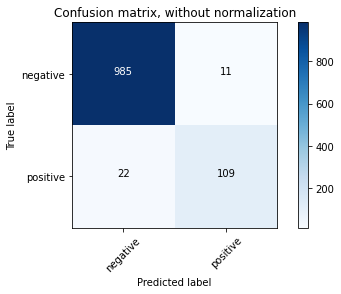

In [45]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm=confusion_matrix(predictY, realY)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure()
plot_confusion_matrix(cm, classes=['negative', 'positive'], title='Confusion matrix, without normalization')

## multi prediction

In [29]:
# 글자만.
from tqdm import tqdm
predictY = []
real_img_Y = []
real_aud_Y = []
predY = []
iteration = 1127
model = multi_model
img_size = (224, 224)
unique_sorted_Y = ['negative','positive']

for i in tqdm(range(iteration)): 
    image_path = image_generator.filepaths[i] # CXR
    audio_mel_path = audio_generator.filepaths[i] # mel-image
    
    
    # get label from testpath
    real_image_y = image_path.split('/')[-2] 
    real_audio_y = audio_mel_path.split('/')[-2]
    
    # pre-processing image
    cropped_image = get_cropped_image(image_path, seg_model)
    cxr_img = image_preprocessing(cropped_image, img_size)
    
    # pre-processing audio
    audio_img = audio_preprocessing(audio_mel_path, img_size)
    
    # get feature vector
    image_feature_vector = DenseNet.predict(cxr_img)
    audio_feature_vector = DenseNet.predict(audio_img)

    # multi-input prediction
    prediction = multi_model.predict([image_feature_vector, audio_feature_vector])[0]
    
    # print(prediction)
    predict = int(np.round(prediction))
    
    #labels에 저장 
    label = unique_sorted_Y[predict] 
    
    # 확률 저장
    predY.append(prediction)
    # print(labels[0], realY[0])
    predictY.append(label)
    real_img_Y.append(real_image_y)
    real_aud_Y.append(real_audio_y)
#     print(label,real_image_y, real_audio_y)

100%|██████████| 1127/1127 [03:36<00:00,  5.21it/s]


validation 데이터로 사용했던 1400여개의 데이터 중 negative 1007개 positive 120개를 랜덤으로 추출하여 CXR의 test데이터와 수를 맞춰 함께 예측을 수행하였다.

Confusion matrix, without normalization
[[996  16]
 [ 11 104]]


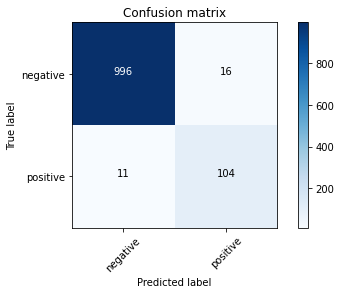

In [30]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm=confusion_matrix(predictY, real_img_Y)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure()
plot_confusion_matrix(cm, classes=['negative', 'positive'], title='Confusion matrix')

In [9]:
def image_preprocessing(cropped_image, img_size):
    
    img = tf.keras.preprocessing.image.array_to_img(cropped_image)
    img = img.resize(img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [10]:
def audio_preprocessing(mel_path, img_size):
    
    img = tf.keras.preprocessing.image.load_img(mel_path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [5]:
# make mel-spectrogram image file
def make_wav2img(audio):
    y, sr = librosa.load(audio, sr = None)
    
    S = librosa.feature.melspectrogram(y, sr=22050, n_mels=128) 
    S_DB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_DB, sr=22050)
    audio = audio.split('/')[-1][:-4]
    image_path = ('../test_image/'+ audio +'.jpg')
    plt.savefig(image_path)

#     res = prediction(image_path,model,feature_model)
    
    return res

## ROC curve and AUC score

In [37]:
multi_realY = []

for i in real_img_Y:
    if i == 'negative':
        multi_realY.append(0)
    else:
        multi_realY.append(1)

In [51]:
img_real_Y = []

for i in realY:
    if i == 'negative':
        img_real_Y.append(0)
    else:
        img_real_Y.append(1)

In [52]:
from sklearn.metrics import roc_curve
fpr_multi, tpr_multi, thresholds_multi = roc_curve(multi_realY, predY)
fpr_img, tpr_img, thresholds_img = roc_curve(img_real_Y,im_pred)

In [53]:
from sklearn.metrics import auc
auc_multi = auc(fpr_multi, tpr_multi)
auc_img = auc(fpr_img, tpr_img)

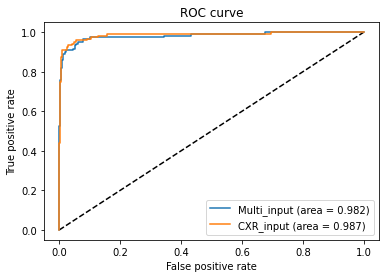

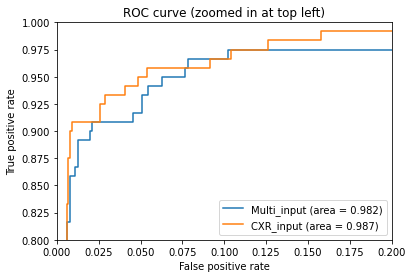

In [55]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_multi, tpr_multi, label='Multi_input (area = {:.3f})'.format(auc_multi))
plt.plot(fpr_img, tpr_img, label='CXR_input (area = {:.3f})'.format(auc_img))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_multi, tpr_multi, label='Multi_input (area = {:.3f})'.format(auc_multi))
plt.plot(fpr_img, tpr_img, label='CXR_input (area = {:.3f})'.format(auc_img))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [1]:
from keras.applications.inception_resnet_v2 import preprocess_input

In [2]:
from keras.applications.densenet import preprocess_input